In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("./Root_Insurance_data.csv")

FileNotFoundError: ignored

In [ ]:
df.head()

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,bid,rank,click,policies_sold
0,unknown,2,1,M,10.0,2,False,0
1,Y,3,1,M,10.0,5,False,0
2,Y,3,2,M,10.0,5,False,0
3,N,3,2,S,10.0,4,False,0
4,unknown,2,2,S,10.0,2,False,0


With the current $10 flat-bid strategy we collect 1878 clicks, 783 of which result in a policy sold.

This means we spend a total of \$18,780 on ads with an efficiency of \$23.98 per customer aquired.

In [ ]:
print("total clicks: ",sum(df.click))
print("policies sold: ",sum(df.policies_sold))
print("cost per customer acquired: ${:0.2f}".format(10*sum(df.click)/sum(df.policies_sold)))

total clicks:  1878
policies sold:  783
cost per customer acquired: $23.98


How often do customers who click ultimatly choose to buy a policy?

In [ ]:
# create dummy variables
xdf = df[["click","policies_sold"]].copy()
xdf[["insured","unknown"]] = pd.get_dummies(df["Currently Insured"])[["Y","unknown"]]
xdf[["cars2","cars3"]] = pd.get_dummies(df["Number of Vehicles"])[[2,3]]
xdf[["drivers2"]] = pd.get_dummies(df["Number of Drivers"])[[1]]
xdf[["married"]] = pd.get_dummies(df["Marital Status"])[["M"]]
xdf[["rank1","rank2","rank3","rank4","rank5"]] = pd.get_dummies(df["rank"])

In [ ]:
xdf.head(10)

,click,policies_sold,insured,unknown,cars2,cars3,drivers2,married,rank1,rank2,rank3,rank4,rank5
0,False,0,0,1,1,0,1,1,0,1,0,0,0
1,False,0,1,0,0,1,1,1,0,0,0,0,1
2,False,0,1,0,0,1,0,1,0,0,0,0,1
3,False,0,0,0,0,1,0,0,0,0,0,1,0
4,False,0,0,1,1,0,0,0,0,1,0,0,0
5,False,0,0,0,1,0,1,1,0,0,0,0,1
6,False,0,1,0,1,0,0,1,0,0,0,1,0
7,False,0,0,0,1,0,1,0,0,0,0,0,1
8,False,0,0,1,0,1,0,1,0,0,0,1,0
9,False,0,0,1,0,0,0,1,1,0,0,0,0


# likelihood to buy policy conditional on ad click

Use sklearn logistic regression to determine the probability that a customer buys a policy *given* that they click our add (controlling for insurance status, marital status, number of drivers, and number of vehicles)

In [ ]:
import statsmodels.api as sm
glm = sm.Logit(xdf["policies_sold"].loc[xdf.click],
    sm.add_constant(xdf[["insured","unknown","cars2","cars3","drivers2","married"]].loc[xdf.click])).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.666937
         Iterations 5


In [ ]:
print(glm.summary())

                           Logit Regression Results                           
Dep. Variable:          policies_sold   No. Observations:                 1878
Model:                          Logit   Df Residuals:                     1871
Method:                           MLE   Df Model:                            6
Date:                Wed, 19 May 2021   Pseudo R-squ.:                 0.01818
Time:                        18:12:51   Log-Likelihood:                -1252.5
converged:                       True   LL-Null:                       -1275.7
Covariance Type:            nonrobust   LLR p-value:                 2.497e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1418      0.123     -1.150      0.250      -0.384       0.100
insured       -0.6084      0.149     -4.096      0.000      -0.900      -0.317
unknown       -0.0210      0.122     -0.172      0.8

Marital status is not statistically significant, nor is Insured status "unknown" (coefficient not statistically different from 0) so we'll not use these variable. 

In [ ]:
glm = sm.Logit(xdf["policies_sold"].loc[xdf.click],
    sm.add_constant(xdf[["insured","cars2","cars3","drivers2"]].loc[xdf.click])).fit()

Optimization terminated successfully.
         Current function value: 0.667040
         Iterations 5


In [ ]:
print(glm.summary())

                           Logit Regression Results                           
Dep. Variable:          policies_sold   No. Observations:                 1878
Model:                          Logit   Df Residuals:                     1873
Method:                           MLE   Df Model:                            4
Date:                Wed, 19 May 2021   Pseudo R-squ.:                 0.01802
Time:                        18:12:51   Log-Likelihood:                -1252.7
converged:                       True   LL-Null:                       -1275.7
Covariance Type:            nonrobust   LLR p-value:                 2.483e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1265      0.084     -1.507      0.132      -0.291       0.038
insured       -0.5946      0.120     -4.947      0.000      -0.830      -0.359
cars2         -0.4059      0.111     -3.667      0.0

Also try with sklearn. The models largely agree.

In [ ]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()
logit.fit(xdf[["insured","cars2","cars3","drivers2"]].loc[xdf.click],
          xdf["policies_sold"].loc[xdf.click])
print(logit.coef_)
print(logit.intercept_)

[[-0.58468738 -0.39755357 -0.46563783  0.25604267]]
[-0.13131774]


In [ ]:
# see if ranking influences policy rates, conditional on click
# none of the coefficients are statistically different from zero

glm_ranks = sm.Logit(xdf["policies_sold"].loc[xdf.click],
    sm.add_constant(xdf[["insured","cars2","cars3","drivers2",
                         "rank1","rank2","rank3","rank4"]].loc[xdf.click])).fit()
print(glm_ranks.summary())

Optimization terminated successfully.
         Current function value: 0.666213
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          policies_sold   No. Observations:                 1878
Model:                          Logit   Df Residuals:                     1869
Method:                           MLE   Df Model:                            8
Date:                Wed, 19 May 2021   Pseudo R-squ.:                 0.01924
Time:                        18:12:51   Log-Likelihood:                -1251.1
converged:                       True   LL-Null:                       -1275.7
Covariance Type:            nonrobust   LLR p-value:                 6.113e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2222      0.326      0.682      0.495      -0.417       0.861
insured       -0.6253      0.

# Click thru rate by rank

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

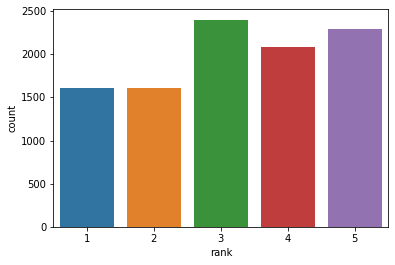

In [ ]:
# barplot count of occurences of each rank
sns.countplot(x="rank",data=df)

In [ ]:
# find the click-through rate by rank of the ad
df.groupby("rank").mean().click

rank
1    0.526381
2    0.287313
3    0.146189
4    0.080421
5    0.021388
Name: click, dtype: float64

In [ ]:
# Average Raqnk for customers who click our ad
r_bar_click = df["rank"].loc[df.click].mean()
n_click = np.sum(df.click)
print(r_bar_click)
print(n_click)

n=10000
r_bar = df["rank"].mean()

t = n_click*(r_bar_click - 1)/(n*(r_bar-1))
print(t)
1/(1+t+t**2+t**3+t**4)


1.992545260915868
1878
0.08534407765212217


0.9146600635522406

In [ ]:
# Average Rank for customers who do NOT click our ad
df["rank"].mean()

3.1841

In [ ]:
t = .2876
1/(1 + t + t**2 + t**3 + t**4)

0.7138045063075129

See if controlling for customer characteristics (insured status, marital status, number of vehicles, number of drivers) affects click thru rates by rank 

In [ ]:
glm_click = sm.Logit(xdf["click"],
    sm.add_constant(xdf[["insured","unknown","married","cars2","cars3","drivers2",
                         "rank1","rank2","rank3","rank4"]])).fit()
print(glm_click.summary())

Optimization terminated successfully.
         Current function value: 0.388893
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  click   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9989
Method:                           MLE   Df Model:                           10
Date:                Wed, 19 May 2021   Pseudo R-squ.:                  0.1949
Time:                        18:12:54   Log-Likelihood:                -3888.9
converged:                       True   LL-Null:                       -4830.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.7038      0.168    -22.000      0.000      -4.034      -3.374
insured        0.1053      0.

In [ ]:
# insurance status not statistically significant, and number of drivers is not statistically significant
for rk in ["rank1","rank2","rank3","rank4","rank5"]:
    y = xdf[["click"]].loc[xdf[rk]==1]
    # there are no instances of unknown insurance status with rank=5
    # remove this "unknown" variable when taking logistic regression of rank=5
    if rk != "rank5":
        x = xdf[["insured","unknown","drivers2","cars2","cars3","married"]].loc[ xdf[rk]==1]
    else:
        x = xdf[["insured","drivers2","cars2","cars3","married"]].loc[ xdf[rk]==1]
    print(sm.Logit(y,sm.add_constant(x)).fit().summary())

Optimization terminated successfully.
         Current function value: 0.688064
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                  click   No. Observations:                 1611
Model:                          Logit   Df Residuals:                     1604
Method:                           MLE   Df Model:                            6
Date:                Wed, 19 May 2021   Pseudo R-squ.:                0.005335
Time:                        18:12:55   Log-Likelihood:                -1108.5
converged:                       True   LL-Null:                       -1114.4
Covariance Type:            nonrobust   LLR p-value:                   0.06442
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2347      0.188      1.247      0.212      -0.134       0.604
insured        0.1905      0.

Most of the veriables fall short of statistical significance except for Martial Status and Number of Vehicles
There's 

In [ ]:
# the only variables that show statistical significance are marital status and number of vehicles

for rk in ["rank1","rank2","rank3","rank4","rank5"]:
    y = xdf[["click"]].loc[xdf[rk]==1]
    x = xdf[["cars2","cars3","married"]].loc[ xdf[rk]==1]
    print(sm.Logit(y,sm.add_constant(x)).fit().summary())

Optimization terminated successfully.
         Current function value: 0.688537
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                  click   No. Observations:                 1611
Model:                          Logit   Df Residuals:                     1607
Method:                           MLE   Df Model:                            3
Date:                Wed, 19 May 2021   Pseudo R-squ.:                0.004651
Time:                        18:12:56   Log-Likelihood:                -1109.2
converged:                       True   LL-Null:                       -1114.4
Covariance Type:            nonrobust   LLR p-value:                   0.01570
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2982      0.082      3.627      0.000       0.137       0.459
cars2         -0.1053      0.

In [ ]:
# none of the customer information variables are overly correlated with each other
pd.get_dummies(df[["Currently Insured", "Number of Vehicles", "Number of Drivers", "Marital Status"]],
               columns=["Currently Insured", "Number of Vehicles", "Number of Drivers", "Marital Status"]).corr()

,Currently Insured_N,Currently Insured_Y,Currently Insured_unknown,Number of Vehicles_1,Number of Vehicles_2,Number of Vehicles_3,Number of Drivers_1,Number of Drivers_2,Marital Status_M,Marital Status_S
Currently Insured_N,1.000000,-0.522415,-0.490018,-0.024843,-0.020346,0.046471,-0.027503,0.027503,-0.026444,0.026444
Currently Insured_Y,-0.522415,1.000000,-0.487308,-0.015743,-0.005911,0.022263,-0.014690,0.014690,-0.014685,0.014685
Currently Insured_unknown,-0.490018,-0.487308,1.000000,0.041536,0.026879,-0.070350,0.043184,-0.043184,0.042093,-0.042093
Number of Vehicles_1,-0.024843,-0.015743,0.041536,1.000000,-0.527298,-0.484922,-0.004986,0.004986,-0.022844,0.022844
Number of Vehicles_2,-0.020346,-0.005911,0.026879,-0.527298,1.000000,-0.487395,-0.040076,0.040076,-0.026989,0.026989
Number of Vehicles_3,0.046471,0.022263,-0.070350,-0.484922,-0.487395,1.000000,0.046374,-0.046374,0.051255,-0.051255
Number of Drivers_1,-0.027503,-0.014690,0.043184,-0.004986,-0.040076,0.046374,1.000000,-1.000000,-0.026827,0.026827
Number of Drivers_2,0.027503,0.014690,-0.043184,0.004986,0.040076,-0.046374,-1.000000,1.000000,0.026827,-0.026827
Marital Status_M,-0.026444,-0.014685,0.042093,-0.022844,-0.026989,0.051255,-0.026827,0.026827,1.000000,-1.000000
Marital Status_S,0.026444,0.014685,-0.042093,0.022844,0.026989,-0.051255,0.026827,-0.026827,-1.000000,1.000000


In [ ]:
# do logistic regression with interaction between rank and customer information
y = df.click
for rk in ["rank1","rank2","rank3","rank4","rank5"]:
    

SyntaxError: ignored

In [ ]:
xdf[["insured","unknown","drivers2","cars2","cars3","married"]].multiply(xdf["rank1"],axis=0).loc

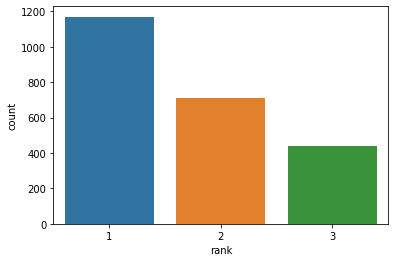

In [ ]:
sns.countplot(x="rank", data = df.loc[ (df["Currently Insured"]=="unknown") & (df["Number of Vehicles"] <= 2)] )

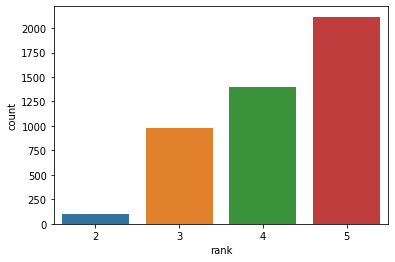

In [ ]:
sns.countplot(x="rank", data = df.loc[ (df["Currently Insured"]!="unknown") & (df["Number of Vehicles"] >= 2)] )

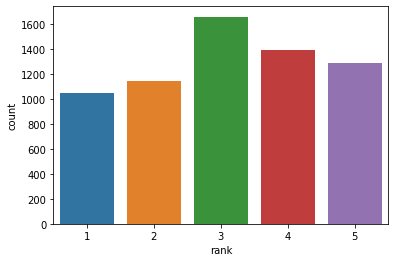

In [ ]:
sns.countplot(x="rank", data = df.loc[ (df["Number of Vehicles"] != 2)] )

$$ p = \mathbb P(X>10) $$

$$ q = 1 - p$$

$$\mathbb P( \mathrm{rank} = r ) = \binom 5 {r-1} p^{5-r} q^r$$

The liklihood function given $n_1,n_2,...,n_5$:
$$ \mathbb P( n_1, \ldots, n_5 | p ) = c(n_1,\ldots,n_5) p^{\sum_{r=1}^5 (5-r)n_r} q^{\sum_{i=1}^5 r n_r} \\
= c p^{n(5- \overline r)} q^{n \overline r} $$

$$ \log \mathbb P (n_1, \ldots, n_5 | p ) = n (5- \overline r) \log p + n \overline r \log (1-p) \\
\frac \partial {\partial p} \log \mathbb P (n_1, \ldots, n_5 | p ) = \frac {n (5-\overline r)} p - \frac {n \overline r} {
(1-p)}$$


# Maximum Likelihood Estimates for Parametric Models

Here, we'll make some assumption about how advertisers generate their bids. First, let's assume that they are drawn from a uniform distribution with a minimum of \\$0 and a maximum of \\$N.

This is a relatively simple model, but we don't have any information about how much other advertisers are bidding other than that it must be greater than \\$0, and perhaps there is some maximum threshold that advertisers are willing to spend on an ad.

Let $\overline r$ be the observed average rank, for some fixed subset of customer characteristics, when we place a flate \\$10 advertisement bid. The maximum likelihood estimate for the probability $$\hat p_{\mathrm{MLE}} = \mathbb P( \text{ ad bid} > 10 ) = \frac {\overline r - 1} 4$$


Asuming a uniform distribution, $ \mathbb P( \text{ ad bid} > 10 ) = \frac {N-10}N$, and the maximum likelihood estimate for the maximum $N$ is $$ \hat N_{\mathrm{MLE}} = \frac {40} {5-\overline r}$$.

For example, among customers with known insurance status and at least two vehicles, our average rank is $\overline r = 4.2$ and corresponds to a max bid of \\$50.20

In [ ]:
r = df["rank"].loc[(df["Currently Insured"]!="unknown")&(df["Number of Vehicles"]>=2)].mean()
print("r = ",r)
print("N = ",40/(5-r))

r =  4.203135205747877
N =  50.1967213114754


On the other hand, if we consider customers with unknown insurance status and one or two vehicles, our average rank is $\overline r = 1.7$, corresponding to a max bid of \\$12.06.

In [ ]:
r = df["rank"].loc[(df["Currently Insured"]=="unknown")&(df["Number of Vehicles"]<=2)].mean()
print("r = ",r)
print("N = ",40/(5-r))

r =  1.6845058264997843
N =  12.064566519135642


# Maximum Likelihood Estimate for Exponential Distribution

Another mehtod to model other advertisers' bids is to use the exponential distribution. This is another useful model since we have little information on competing bids from other advertisers. We know their bid must be positive, but we don't know how large they may be, or what their average or variation is. We can, however, infer how often their bids are greater than our flat \\$10 bid, based on our placement in the rankings.

Exponential distributions tend to be useful when the only information is the rate at which an event occurs. For one, the exponential minimizes entropy among all distributions for $x>0$. So in a sense, it assumes the "least" information about actual distribution.

Moreover, in this context, the "memoryless" property of the exponential distribution means that if we condition for bids greater than \\$10, they also form an exponential distribution.

A random exponential variable with rate $\lambda$ is distributed with
$$
    f(x) = \frac 1 \lambda e^{-x/\lambda} \text{, for } x>0.
$$

The rate $\lambda$ can be determined by estimateing the probability other advertisers bid more than \\$10
$$ \mathbb P(\mathrm{ad\,bid}>10) = e^{-10/\lambda}.$$

If $\overline r$ is the average rank observed for some subset of customer characteristics, the maximum likelihood estimate of the rate $\lambda$ is $$\hat \lambda_{\mathrm{MLE}} = \frac {-10} {\log \frac{\overline r - 1}{4}}$$.

For example, among customers with known insurance status and at least two vehicles, our average rank is $\overline r$ = 4.2 and corresponds to a rate parameter of $\hat\lambda_{\mathrm{MLE}}=$\\$45.01, so other advertisers are outbidding us by a lot.

In [ ]:
r = df["rank"].loc[(df["Currently Insured"]!="unknown")&(df["Number of Vehicles"]>=2)].mean()
print("Average rank r = ",r)
print("rate = ",-10/np.log((r-1)/4))

Average rank r =  4.203135205747877
rate =  45.011736530017885


On the other hand, if we consider customers with unknown insurance status and one or two vehicles, our average rank is $\overline r = 1.7$, corresponding to a rate parameter of $\lambda=$\\$5.66, and we are consistently overbidding for customers.

In [ ]:
r = df["rank"].loc[(df["Currently Insured"]=="unknown")&(df["Number of Vehicles"]<=2)].mean()
print("r = ",r)
print("rate = ",-10/np.log((r-1)/4))

r =  1.6845058264997843
rate =  5.66459111949206


# How does bid strategy ultimately affect sales?

Now, let's consider a single customer whose characteristics are known (insurance status, marital status, number of drivers, and number of vehicles). We need to determine an optimal dollar amount $b$ to bid for an ad for this customer.

Our bid will determine our place in the ad rankings, and we'll use the exponential distribution to model the other advertisers bids based on the average ranking for a flat \\$10 bid. If $\overline r$ is the average rank for customers of this type, so that $$\lambda = \hat \lambda_{\mathrm{MLE}}= \frac {10}{\log \big( 4/(\overline r -1) \big)}$$ is the maximum likelihood estimate of the rate parameter, then the probability that our bid is $\mathrm{rank}=r$ is $$\mathbb P(\mathrm{rank}=r | \mathrm{bid}=b) = \binom 4 {r-1} (1 - e^{-b/\lambda})^{r-1}( e^{-b/\lambda})^{5-r}.$$

If our ad is at rank $r$ in the rankings, we can estimate the chance that that a customer will click our ad, $\mathbb P( \mathrm{click} | \mathrm{rank}=r)$. A higher bid will result in a higher rank, on average, and we have seen that higher ranked ads get clicked much more frequently than lower ranked ads. These click rates don't seem to depend on the characteristic of the customer, so we'll take them to be same for all customers $$\mathbb P( \mathrm{click} | \mathrm{rank}=r) = \theta_r.$$

Finally, using the customer characteristics, we can estimate the probability of selling a policy when the customer clicks our ad, $\mathbb P( \mathrm{buy} | \mathrm{click})$, using the logistic regression from above.

Thus can estimate the probability of selling a policy based on the bid size: $$\mathbb P(\mathrm{buy} | \mathrm{bid}=b) = \mathbb P( \mathrm{buy} | \mathrm{click}) \sum_{r=1}^5 \mathbb P( \mathrm{click} | \mathrm{rank}=r)\mathbb P(\mathrm{rank}=r | \mathrm{bid}=b)$$

$$\mathbb P(\mathrm{buy} | \mathrm{bid}=b) = \mathbb P( \mathrm{buy} | \mathrm{click}) \sum_{r=1}^5 \theta_r \binom 4 {r-1} (1 - e^{-b/\lambda})^{r-1}( e^{-b/\lambda})^{5-r}$$


# Assessing the efficiency of a bid strategy

The goal for developing a bid strategy is to maximize the efficiency of the advertising budget, while selling at least 400 total policies.

Thus we need to estimate the total number of policies a bid strategy will sell, the expected cost of the bid strategy, and ultimately the expected efficiency of customer acquisition.

There are 36=3x3x2x2 possible customer characteristics. Label these from 1 to 36, and suppose we end up with $N_i$ customers for each $i=1,\ldots,36$. These are random quantities, but we have some idea of the proportion they make up from the data collected so far.

From the data, we also have an estimate of $p_i$, the probability to buy a policy conditioned on a click; $\lambda_i$, the rate at which other advertisers bid for customers of that type; and $\theta_r$ the rate of expected clicks for ads at rank=$r$.

Suppose we propose a bid strategy where we always bid $b_i$ dollars for customer of type $i$. Then we can calcuate the expected number of policies sold:
$$ \mathbb E [ \mathrm{\,\#policies\,\,sold\,} ]  =\sum_{i=1}^{36} \sum_{r=1}^5 N_i p_i \theta_r \binom{4}{r-1} \big(e^{-b_i/\lambda_i}\big)^{r-1}  \big(1- e^{- b_i/\lambda_i}\big)^{5-r} $$

We have to pay for our bid only if our ad is clicked, so we can also estimate the total expenses as
$$ \mathbb E[ \mathrm{Cost} ] = \sum_{i=1}^{36} \sum_{r=1}^5 b_i M_i \theta_r \binom 4 {r-1} \big(e^{-b_i/\lambda_i}\big)^{r-1}  \big(1- e^{- b_i/\lambda_i}\big)^{5-r}, $$
where $M_i$ is the number of clicks per category.



$$ \theta_r \propto c^r$$

The question of maximizing efficiency can now be posed as a constrained optimization problem: Find
$$ \underset {b_i\geq 0} {\arg\,\max\,} \mathcal L(b_1,\ldots,b_{36})$$
where
$$ \mathcal L(b_1,\ldots,b_{36}) = \frac {\mathbb E[ \mathrm{\# policies\,sold\,}]}{\mathbb E [\mathrm{Cost}]} = \frac {\sum_{i=1}^{36} \sum_{r=1}^5 N_i p_i \theta_r \binom{4}{r-1} \big( e^{-b_i/\lambda_i}\big)^{r-1}  \big(1- e^{- b_i/\lambda_i}\big)^{5-r}} {\sum_{i=1}^{36} \sum_{r=1}^5 b_i N_i \theta_r \binom 4 {r-1} \big(e^{-b_i/\lambda_i}\big)^{r-1}  \big(1- e^{- b_i/\lambda_i}\big)^{5-r}} $$
subject to the constraint
$$ \sum_{i=1}^{36} \sum_{r=1}^5 N_i p_i \theta_r \binom{4}{r-1} \big(e^{-b_i/\lambda_i}\big)^{r-1}  \big(1 - e^{- b_i/\lambda_i}\big)^{5-r} \geq 400. $$

(Strictly, this constraint says the *expected* number of policies is at least 400. If we want, for example, 95\% confidence that the true number of policies will be at least 400, we can increase the lower bound appropriatly using a variance extimate).

Let us work with the inverse of the efficiency function, namely
$$ \frac {\mathbb{E}[\mathrm{Cost}]}{\mathbb E[ \mathrm{\# policies\,sold\,}]}.$$
This is because optimization algorithms are written to find minimums, so we may choose to minimize the inverse of the efficiency function instead of maximizing the efficiency function directly. In addition, if we choose to set the constraint to a fixed value, instead of being any value over 400, we are simply just optimizing(specifically minimizing) the expected cost, constrained to expected number of sold policies fixed to some value, instead of the inverse of the expected cost.

We keep the constraint, which is the expected number of policies sold, to be $C \in \{400,500,600,700,800,900\}.$ After fixing the constraint, we run an algorithm to minimize $\mathbb{E}[\text{Cost}]$ subject to the constraint $\mathbb{E}[\text{# policies sold}] = C.$ 

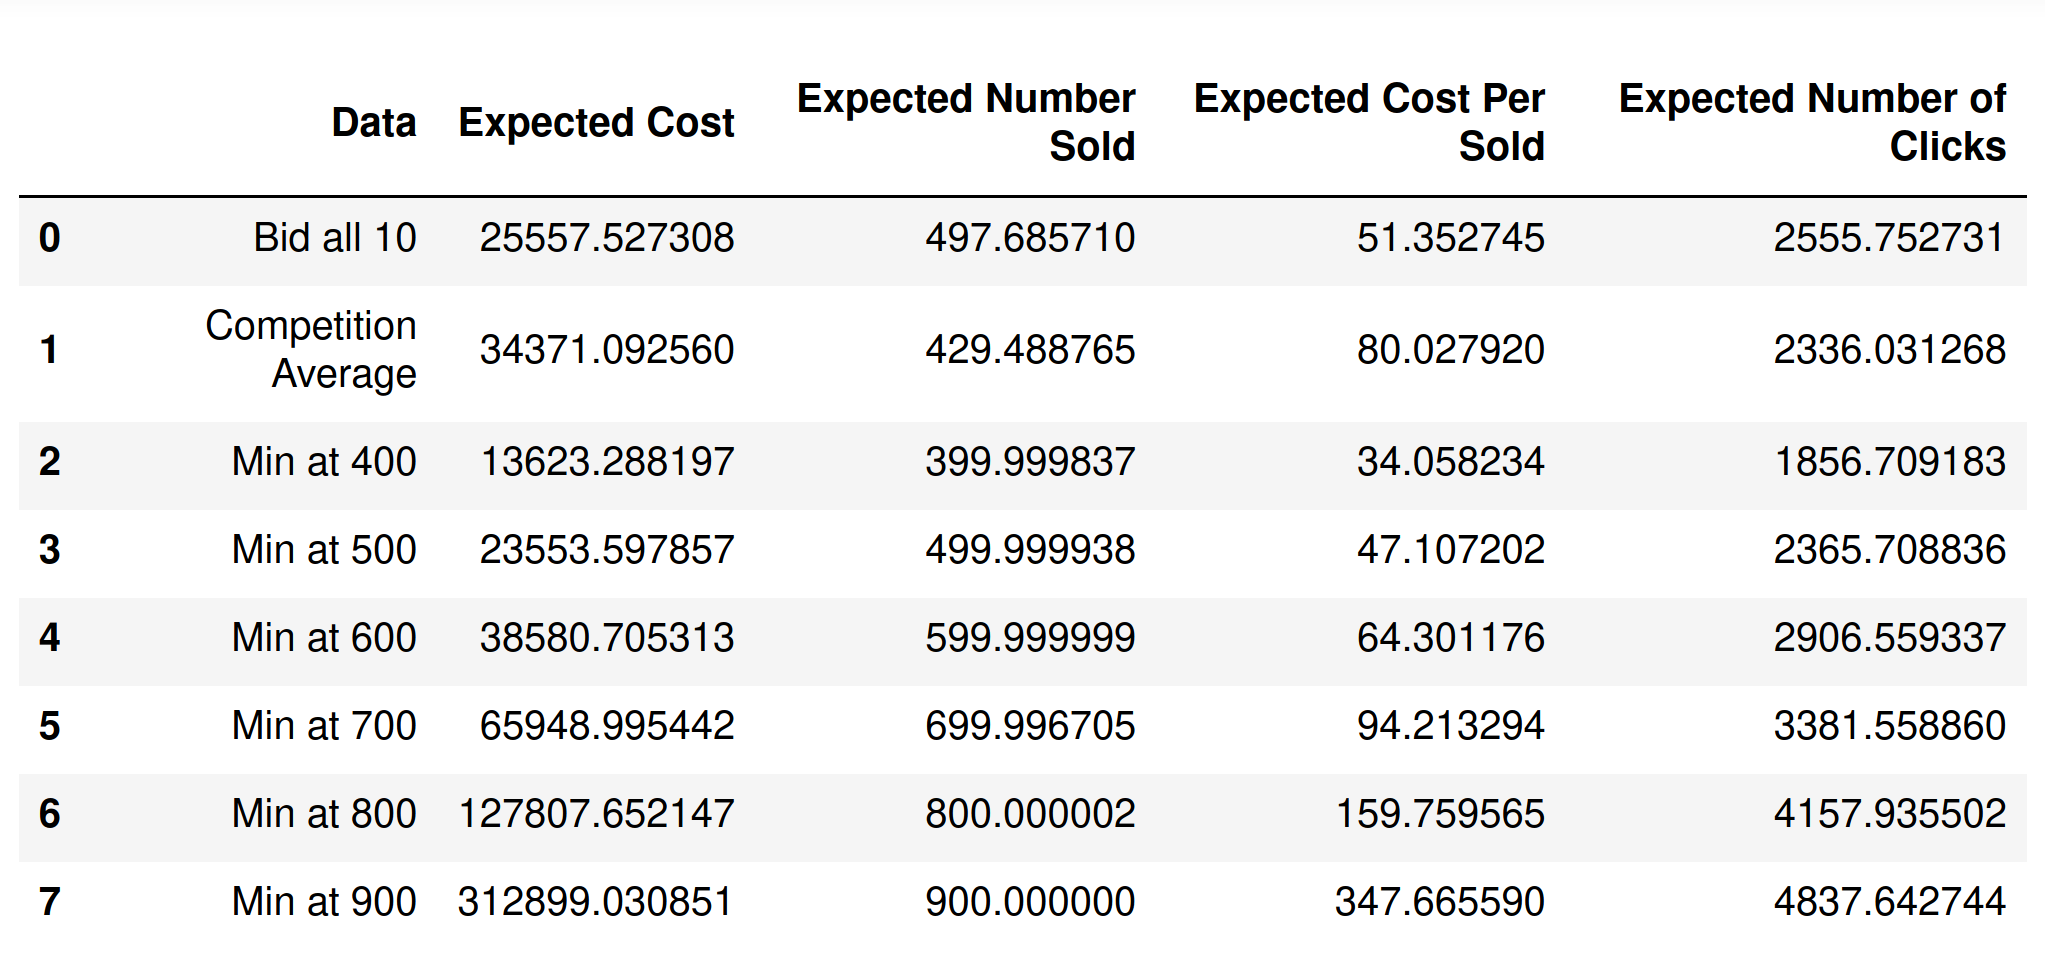

Caveat: Might not be true minimal values fixing the expected number sold to be some multiple of 100.

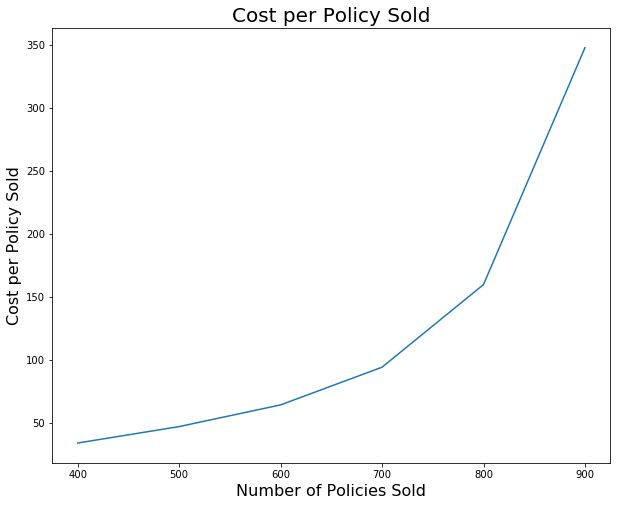